```
From: https://github.com/ksatola
Version: 0.0.0

TODOs
1. 
```

# Big Mart Sales Prediction

## Table of Contents

- [Model 1 - Mean](#m1)
- [Model 2 - Average Sales by Location](#m2)
- [Model 3 - Linear Regression (2 features)](#m3)
- [Model 4 - Linear Regression (3 features)](#m4)
- [Model 5 - Linear Regression (more features)](#m5)
- [Selecting the right features for your model](#feat)
- [Regularization](#reg)
- [Model 6 - Ridge Regression](#m6)
    - Hyperparameters tuning with CV
- [Model 7 - Lasso Regression](#m7)
- [Model 7b - Least Angle Regression (LARS) Regression](#m7b)
- [Model 8 - Elastic Net Regression](#m8)
    - Hyperparameters tuning
- [Summary](#sum)

In [3]:
# Connect with underlying Python code
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../src')

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [5]:
from datasets import (
    get_dataset,
)

In [6]:
#pd.set_option("display.max_rows", 200)
#pd.set_option("display.max_columns", 100)
pd.set_option("display.max_columns", None)
#pd.set_option("display.max_colwidth", 200)

### Big Mart Outlets
The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and predict the sales of each product at a particular outlet. Using this model, BigMart will try to understand the properties of products and outlets which play a key role in increasing sales. Please note that the data may have missing values as some stores might not report all the data due to technical glitches. Hence, it will be required to treat them accordingly. 
```
Variable					Description
Item_Identifier				Unique product ID
Item_Weight					Weight of product
Item_Fat_Content			Whether the product is low fat or not
Item_Visibility				The % of total display area of all products in a store allocated to the particular product
Item_Type					The category to which the product belongs
Item_MRP					Maximum Retail Price (list price) of the product
Outlet_Identifier			Unique store ID
Outlet_Establishment_Year	The year in which store was established
Outlet_Size					The size of the store in terms of ground area covered
Outlet_Location_Type		The type of city in which the store is located
Outlet_Type					Whether the outlet is just a grocery store or some sort of supermarket
Item_Outlet_Sales			TARGET: Sales of the product in the particular store. This is the outcome variable to be predicted.
```

In [7]:
# target = 'Item_Outlet_Sales'
df = get_dataset('big_mart_outlets')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [9]:
df.shape

(8523, 12)

In [10]:
y = df['Item_Outlet_Sales']
X = df.drop(columns=['Item_Outlet_Sales'])

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
# Results Data Frame
df_res = pd.DataFrame(columns=['Model', 'RMSE', 'Adjusted_RMSE', 'R2', 'Adjusted_R2'])
df_res

,Model,RMSE,Adjusted_RMSE,R2,Adjusted_R2


In [13]:
row = {
    'Model' : 1, 
    'RMSE' : 2, 
    'Adjusted_RMSE' : 3, 
    'R2' : 4, 
    'Adjusted_R2' : 5,
}
#df_res = df_res.append(row, ignore_index=True)
df_res

,Model,RMSE,Adjusted_RMSE,R2,Adjusted_R2


---
<a id='m1'></a>

In [26]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def rmse(y_test, y_pred): return mean_squared_error(y_test, y_pred)**(0.5)
def rmse_adj(y_test, y_pred, n_features): return (np.sum((y_test - y_pred)**2) / (len(y_test) - n_features - 1))**(0.5)
def r2(y_test, y_pred): return r2_score(y_test, y_pred)
def r2_adj(y_test, y_pred, n_features): return 1 - (1 - r2(y_test, y_pred)) * (len(y_test) - 1) / (len(y_test) - n_features - 1)

In [23]:
n_features = X_test.shape[1]
n_features

11

In [38]:
def print_metrics(y_test, y_pred, n_features):
    
    rmsev = rmse(y_test, y_pred)
    rmse_adjv = rmse_adj(y_test, y_pred, n_features)
    r2v = r2(y_test, y_pred)
    r2_adjv = r2_adj(y_test, y_pred, n_features)
    
    print(f'{"RMSE:":>12} {rmsev:>10.4f}')
    print(f'{"RMSE ADJ:":>12} {rmse_adjv:>10.4f}')
    print(f'{"R2:":>12} {r2v:>10.4f}')
    print(f'{"R2 ADJ:":>12} {r2_adjv:>10.4f}')
    
    return rmsev, rmse_adjv, r2v, r2_adjv

## Model 1 - Mean
Even without any knowledge of machine learning, you can say that if you have to predict sales for an item – it would be the average over last few days/months/weeks.

In [15]:
print('Mean of Target Variable : ', y_train.mean())

Mean of Target Variable :  2204.8825196781763


In [16]:
y_train.shape[0]

5966

In [17]:
# predict the target on the train dataset
m1 = [y_train.values.mean() for i in range(y_train.shape[0])]
m1[:5]

[2204.8825196781763,
 2204.8825196781763,
 2204.8825196781763,
 2204.8825196781763,
 2204.8825196781763]

In [18]:
# predict the target on the test dataset
m1_pred = [y_train.values.mean() for i in range(y_test.shape[0])]
m1_pred[:5]

[2204.8825196781763,
 2204.8825196781763,
 2204.8825196781763,
 2204.8825196781763,
 2204.8825196781763]

In [20]:
# Root Mean Squared Error on testing dataset
m1_rmse = rmse(y_test, m1_pred)
m1_rmse

1675.4635583171257

In [24]:
m1_rmse_adj = rmse_adj(y_test.values.ravel(), m1_pred, n_features)
m1_rmse_adj

1679.408925377286

In [25]:
m1_r2 = r2(y_test, m1_pred)
m1_r2

-0.002208005062074303

In [27]:
# Adjusted R-Square
m1_r2_adj = r2_adj(y_test.values.ravel(), m1_pred, n_features)
m1_r2_adj

-0.006539748895348474

In [39]:
print_metrics(y_test.values.ravel(), m1_pred, n_features)

       RMSE:  1675.4636
   RMSE ADJ:  1679.4089
         R2:    -0.0022
     R2 ADJ:    -0.0065


(1675.4635583171257,
 1679.408925377286,
 -0.002208005062074303,
 -0.006539748895348474)

In [28]:
row = {
    'Model' : 'Model 1 - Mean', 
    'RMSE' : m1_rmse, 
    'Adjusted_RMSE' : m1_rmse_adj, 
    'R2' : m1_r2, 
    'Adjusted_R2' : m1_r2_adj,
}
df_res = df_res.append(row, ignore_index=True)
df_res

,Model,RMSE,Adjusted_RMSE,R2,Adjusted_R2
0,Model 1 - Mean,1675.463558,1679.408925,-0.002208,-0.00654


---
<a id='m2'></a>

## Model 2 – Average Sales by Location
We know that location plays a vital role in the sales of an item. Therefore let us use the data of the column ‘Outlet_Location_Type’. So basically, let us calculate the average sales for each location type and predict accordingly. Let's notice that by using a characteristic [location], we have reduced the RMSE.

In [22]:
df['Outlet_Location_Type'].value_counts()

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

In [23]:
df['Outlet_Location_Type'].value_counts().count()

3

In [24]:
df['Outlet_Location_Type'] = pd.Categorical(df['Outlet_Location_Type'])
df['Outlet_Location_Type'].cat.categories

Index(['Tier 1', 'Tier 2', 'Tier 3'], dtype='object')

In [25]:
df['Outlet_Location_Type'].unique()

['Tier 1', 'Tier 3', 'Tier 2']
Categories (3, object): ['Tier 1', 'Tier 3', 'Tier 2']

In [26]:
df_pred = df.copy()
df_pred['m2_pred'] = 0

In [27]:
pred_train = []

for cat in df['Outlet_Location_Type'].unique():
    print(cat)
    
    cat_mean = df[df['Outlet_Location_Type'] == cat]['Item_Outlet_Sales'].mean()
    print(f"Mean: {cat_mean}")
    
    cat_means = [cat_mean for i in range(df[df['Outlet_Location_Type'] == cat].shape[0])]
    m2_rmse = mean_squared_error(df[df['Outlet_Location_Type'] == cat]['Item_Outlet_Sales'], cat_means)**(0.5)
    print(f"RMSE: {m2_rmse}")
    
    df_pred.loc[df_pred['Outlet_Location_Type'] == cat, 'm2_pred'] = cat_mean
    
    m2_rmse_adj = (np.sum((df[df['Outlet_Location_Type'] == cat]['Item_Outlet_Sales'] - cat_means)**2) / (len(cat_means) - 1 - 1))**(0.5)
    
    row = {
        'Model' : f'Model 2 - Average Sales by Location - {cat}', 
        'RMSE' : m2_rmse, 
        'Adjusted_RMSE' : m2_rmse_adj, 
        'R2' : r2_score(df[df['Outlet_Location_Type'] == cat]['Item_Outlet_Sales'], cat_means), 
        'Adjusted_R2' : 1 - (1 - R2) * (len(y_test) - 1) / (len(y_test) - -1 - 1),
    }
    print(row)
    df_res = df_res.append(row, ignore_index=True)

Tier 1
Mean: 1876.9091591289784
RMSE: 1561.3222798343375
{'Model': 'Model 2 - Average Sales by Location - Tier 1', 'RMSE': 1561.3222798343375, 'Adjusted_RMSE': 1561.9765108623512, 'R2': 0.0, 'Adjusted_R2': -0.001816058247423591}
Tier 3
Mean: 2279.6276513432836
RMSE: 1912.165871003965
{'Model': 'Model 2 - Average Sales by Location - Tier 3', 'RMSE': 1912.165871003965, 'Adjusted_RMSE': 1912.736922493776, 'R2': 0.0, 'Adjusted_R2': -0.001816058247423591}
Tier 2
Mean: 2323.990558850988
RMSE: 1520.2705303477085
{'Model': 'Model 2 - Average Sales by Location - Tier 2', 'RMSE': 1520.2705303477085, 'Adjusted_RMSE': 1520.816702641365, 'R2': 0.0, 'Adjusted_R2': -0.001816058247423591}


In [28]:
df_pred.sample(10)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,m2_pred
1127,NCM05,NaN,Low Fat,0.059557,Health and Hygiene,263.7226,OUT027,1985,Medium,Tier 3,Supermarket Type3,6872.3876,2279.627651
6743,DRF51,15.750,Low Fat,0.166514,Dairy,38.0506,OUT018,2009,Medium,Tier 3,Supermarket Type2,265.6542,2279.627651
4061,NCO55,12.800,Low Fat,0.152378,Others,108.1938,OUT010,1998,NaN,Tier 3,Grocery Store,428.7752,2279.627651
4549,DRI39,13.800,Low Fat,0.097611,Dairy,54.8930,OUT017,2007,NaN,Tier 2,Supermarket Type1,679.1160,2323.990559
8283,FDF08,14.300,Regular,0.065340,Fruits and Vegetables,89.1856,OUT045,2002,NaN,Tier 2,Supermarket Type1,1845.5976,2323.990559
6329,FDA50,16.250,Low Fat,0.087175,Dairy,98.3410,OUT046,1997,Small,Tier 1,Supermarket Type1,1351.5740,1876.909159
2038,NCN14,19.100,Low Fat,0.092438,Others,185.2608,OUT017,2007,NaN,Tier 2,Supermarket Type1,1470.0864,2323.990559
3544,NCJ54,9.895,Low Fat,0.060017,Household,230.8642,OUT013,1987,High,Tier 3,Supermarket Type1,4414.9198,2279.627651
8043,DRA12,11.600,Low Fat,0.068535,Soft Drinks,143.0154,OUT010,1998,NaN,Tier 3,Grocery Store,283.6308,2279.627651
3418,DRL37,15.500,Low Fat,0.053455,Soft Drinks,43.6770,OUT049,1999,Medium,Tier 1,Supermarket Type1,562.6010,1876.909159


In [29]:
df_res

,Model,RMSE,Adjusted_RMSE,R2,Adjusted_R2
0,Model 1 - Mean,1675.463558,1679.408925,-0.002208,-0.006540
1,Model 2 - Average Sales by Location - Tier 1,1561.322280,1561.976511,0.000000,-0.001816
2,Model 2 - Average Sales by Location - Tier 3,1912.165871,1912.736922,0.000000,-0.001816
3,Model 2 - Average Sales by Location - Tier 2,1520.270530,1520.816703,0.000000,-0.001816


---
<a id='m3'></a>

## Model 3 – Linear Regression (2 features)
Using the right features would improve our model. So now let us use two features, MRP and the store establishment year to estimate sales.

In [30]:
from sklearn.linear_model import LinearRegression

In [31]:
y = df['Item_Outlet_Sales']
X = df.loc[:, ['Outlet_Establishment_Year', 'Item_MRP']]

In [32]:
X[:5]

,Outlet_Establishment_Year,Item_MRP
0,1999,249.8092
1,2009,48.2692
2,1999,141.6180
3,1998,182.0950
4,1987,53.8614


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [34]:
m3 = LinearRegression()
m3.fit(X_train, y_train)

LinearRegression()

In [35]:
m3_pred = m3.predict(X_test)

In [40]:
print_metrics(y_test.values.ravel(), m3_pred, n_features)

       RMSE:  1375.8402
   RMSE ADJ:  1379.0800
         R2:     0.3242
     R2 ADJ:     0.3213


(1375.84020278901, 1379.0800193694315, 0.3241911324965928, 0.32127015114392576)

In [37]:
np.mean((m3_pred - y_test)**2)**(0.5)

1375.84020278901

In [39]:
# calculate coefficients
coeff = pd.DataFrame(X_train.columns)
coeff['Coefficient Estimate'] = pd.Series(m3.coef_)
coeff

,0,Coefficient Estimate
0,Outlet_Establishment_Year,-12.264690
1,Item_MRP,15.581799


In [42]:
row = {
    'Model' : 'Model 3 – Linear Regression (2 features)', 
    'RMSE' : m3_rmse, 
    'Adjusted_RMSE' : m3_rmse_adj, 
    'R2' : R2, 
    'Adjusted_R2' : R2a,
}
df_res = df_res.append(row, ignore_index=True)
df_res

,Model,RMSE,Adjusted_RMSE,R2,Adjusted_R2
0,Model 1 - Mean,1675.463558,1679.408925,-0.002208,-0.006540
1,Model 2 - Average Sales by Location - Tier 1,1561.322280,1561.976511,0.000000,-0.001816
2,Model 2 - Average Sales by Location - Tier 3,1912.165871,1912.736922,0.000000,-0.001816
3,Model 2 - Average Sales by Location - Tier 2,1520.270530,1520.816703,0.000000,-0.001816
4,Model 3 – Linear Regression (2 features),1375.840203,1376.648016,0.324191,0.323662


---
<a id='m4'></a>

## Model 4 – Linear Regression (3 features)
Let us introduce another feature ‘weight’. Now let’s build a regression model with these three features.

In [43]:
y = df['Item_Outlet_Sales']
X = df.loc[:, ['Outlet_Establishment_Year', 'Item_MRP', 'Item_Weight']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

m4 = LinearRegression()
m4.fit(X_train, y_train)
m4_pred = m4.predict(X_test)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

It produces an error, because item weights column have some missing values. So let us impute it with the mean of other non-null entries.

In [44]:
df_pred['Item_Weight'].fillna((df_pred['Item_Weight'].mean()), inplace=True)

In [45]:
y = df_pred['Item_Outlet_Sales']
X = df_pred.loc[:, ['Outlet_Establishment_Year', 'Item_MRP', 'Item_Weight']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

m4 = LinearRegression()
m4.fit(X_train, y_train)
m4_pred = m4.predict(X_test)

In [46]:
m4_rmse = mean_squared_error(y_test, m4_pred)**(0.5)
m4_rmse

1375.8543827589144

In [47]:
m4_rmse_adj = (np.sum((y_test - m4_pred)**2) / (len(y_test) - X_test.shape[1] - 1))**(0.5)
m4_rmse_adj

1376.931794343568

In [48]:
coeff = pd.DataFrame(X_train.columns)
coeff['Coefficient Estimate'] = pd.Series(m4.coef_)
coeff

,0,Coefficient Estimate
0,Outlet_Establishment_Year,-12.263612
1,Item_MRP,15.583654
2,Item_Weight,-1.629517


In [49]:
# R-Square
R2 = m4.score(X_test, y_test)
R2

0.32417720210152823

The only drawback of R2 is that if new predictors (X) are added to our model, R2 only increases or remains constant but it never decreases. We can not judge that by increasing complexity of our model, are we making it more accurate? That is why, we use **Adjusted R-Square**. The Adjusted R-Square is the modified form of R-Square that has been adjusted for the number of predictors in the model. It incorporates model’s degree of freedom. The adjusted R-Square only increases if the new term improves the model accuracy.

In [50]:
# Adjusted R-Square
R2a = 1 - (1 - R2) * (len(y) - 1) / (len(y) - X_test.shape[1] - 1)
R2a

0.32393920839408663

In [51]:
row = {
    'Model' : 'Model 4 – Linear Regression (4 features)', 
    'RMSE' : m4_rmse, 
    'Adjusted_RMSE' : m4_rmse_adj, 
    'R2' : R2, 
    'Adjusted_R2' : R2a,
}
df_res = df_res.append(row, ignore_index=True)
df_res

,Model,RMSE,Adjusted_RMSE,R2,Adjusted_R2
0,Model 1 - Mean,1675.463558,1679.408925,-0.002208,-0.006540
1,Model 2 - Average Sales by Location - Tier 1,1561.322280,1561.976511,0.000000,-0.001816
2,Model 2 - Average Sales by Location - Tier 3,1912.165871,1912.736922,0.000000,-0.001816
3,Model 2 - Average Sales by Location - Tier 2,1520.270530,1520.816703,0.000000,-0.001816
4,Model 3 – Linear Regression (2 features),1375.840203,1376.648016,0.324191,0.323662
5,Model 4 – Linear Regression (4 features),1375.854383,1376.931794,0.324177,0.323939


---
<a id='m5'></a>

## Model 5 – Linear Regression (more features)
Now let us built a model containing all the features. While building the regression models, so far we have only used continuous features. This is because we need to treat categorical variables differently before they can used in linear regression model. There are different techniques to treat them, here we use `one hot encoding` (convert each class of a categorical variable as a feature). Other than that we need to impute the missing values for outlet size.

In [17]:
df_pred = get_dataset('big_mart_outlets')
df_pred.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [18]:
# Data pre-processing
df_pred.drop(['Item_Identifier'], axis=1, inplace=True)

# impute missing values
df_pred['Item_Weight'].fillna((df_pred['Item_Weight'].mean()), inplace=True)
df_pred['Item_Visibility'] = df_pred['Item_Visibility'].replace(0, np.median(df_pred['Item_Visibility']))
df_pred['Outlet_Establishment_Year'] = 2013 - df_pred['Outlet_Establishment_Year']
df_pred['Outlet_Size'].fillna('Small', inplace=True)

In [19]:
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                8523 non-null   float64
 1   Item_Fat_Content           8523 non-null   object 
 2   Item_Visibility            8523 non-null   float64
 3   Item_Type                  8523 non-null   object 
 4   Item_MRP                   8523 non-null   float64
 5   Outlet_Identifier          8523 non-null   object 
 6   Outlet_Establishment_Year  8523 non-null   int64  
 7   Outlet_Size                8523 non-null   object 
 8   Outlet_Location_Type       8523 non-null   object 
 9   Outlet_Type                8523 non-null   object 
 10  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 732.6+ KB


In [20]:
# create dummy variables to convert categorical into numeric values
cat_columns = list(df_pred.select_dtypes(include=['object']).columns)
print(cat_columns)

dummies = pd.get_dummies(df_pred[cat_columns], prefix=cat_columns)

df_pred.drop(cat_columns, axis=1, inplace=True)

['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']


In [23]:
df_pred.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
0,9.30,0.016047,249.8092,14,3735.1380
1,5.92,0.019278,48.2692,4,443.4228
2,17.50,0.016760,141.6180,14,2097.2700
3,19.20,0.053931,182.0950,15,732.3800
4,8.93,0.053931,53.8614,26,994.7052


In [24]:
X = pd.concat([df_pred, dummies], axis=1)
X = X.drop(columns=['Item_Outlet_Sales']) # TARGET
y = df_pred['Item_Outlet_Sales']

In [25]:
X.shape

(8523, 45)

In [26]:
# Modelling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

m5 = LinearRegression()
m5.fit(X_train, y_train)
m5_pred = m5.predict(X_test)

NameError: name 'LinearRegression' is not defined

In [60]:
m5_rmse = mean_squared_error(y_test, m5_pred)**(0.5)
m5_rmse

1100.200159751828

In [61]:
m5_rmse_adj = (np.sum((y_test - m5_pred)**2) / (len(y_test) - X_test.shape[1] - 1))**(0.5)
m5_rmse_adj

1110.2319247647238

In [62]:
coeff = pd.DataFrame(X_train.columns)
coeff['Coefficient Estimate'] = pd.Series(m5.coef_)
coeff

,0,Coefficient Estimate
0,Item_Weight,-1.641750
1,Item_Visibility,-462.265345
2,Item_MRP,15.804651
3,Outlet_Establishment_Year,15.840419
4,Item_Fat_Content_LF,-48.410743
5,Item_Fat_Content_Low Fat,0.100276
6,Item_Fat_Content_Regular,79.480907
7,Item_Fat_Content_low fat,36.085950
8,Item_Fat_Content_reg,-67.256389
9,Item_Type_Baking Goods,-22.668459


In [63]:
# R-Square
R2 = m5.score(X_test, y_test)
R2

0.5678531993402369

In [64]:
# Adjusted R-Square
R2a = 1 - (1 - R2) * (len(y) - 1) / (len(y) - X_test.shape[1] - 1)
R2a

0.5655591559251503

In [65]:
row = {
    'Model' : 'Model 5 – Linear Regression (more features)', 
    'RMSE' : m5_rmse, 
    'Adjusted_RMSE' : m5_rmse_adj, 
    'R2' : R2, 
    'Adjusted_R2' : R2a,
}
df_res = df_res.append(row, ignore_index=True)
df_res

,Model,RMSE,Adjusted_RMSE,R2,Adjusted_R2
0,Model 1 - Mean,1675.463558,1679.408925,-0.002208,-0.006540
1,Model 2 - Average Sales by Location - Tier 1,1561.322280,1561.976511,0.000000,-0.001816
2,Model 2 - Average Sales by Location - Tier 3,1912.165871,1912.736922,0.000000,-0.001816
3,Model 2 - Average Sales by Location - Tier 2,1520.270530,1520.816703,0.000000,-0.001816
4,Model 3 – Linear Regression (2 features),1375.840203,1376.648016,0.324191,0.323662
5,Model 4 – Linear Regression (4 features),1375.854383,1376.931794,0.324177,0.323939
6,Model 5 – Linear Regression (more features),1100.200160,1110.231925,0.567853,0.565559


---
<a id='feat'></a>

## Selecting the right features for your model
When we have a high dimensional data set, it would be highly inefficient to use all the variables since some of them might be imparting redundant information. We would need to select the right set of variables which give us an accurate model as well as are able to explain the dependent variable well. There are multiple ways to select the right set of variables for the model. First among them would be the business understanding and domain knowledge. For instance while predicting sales we know that marketing efforts should impact positively towards sales and is an important feature in your model. We should also take care that the variables we’re selecting should not be correlated among themselves.

Instead of manually selecting the variables, we can automate this process by using forward or backward selection. `Forward selection` starts with most significant predictor in the model and adds variable for each step. `Backward elimination` starts with all predictors in the model and removes the least significant variable for each step. Selecting criteria can be set to any statistical measure like R-square, t-stat etc.

### Interpretation of Regression Plots
Take a look at the residual vs fitted values plot.

Text(0.5, 1.0, 'Residual plot')

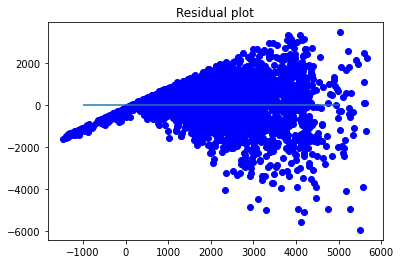

In [66]:
x_plot = plt.scatter(m5_pred, (m5_pred - y_test), c='b')
plt.hlines(y=0, xmin=-1000, xmax=5000)
plt.title('Residual plot')

This shape indicates `Heteroskedasticity` - the presence of non-constant variance in the error terms. We can clearly see that the variance of error terms (`residuals`) is not constant. Generally, non-constant variance arises in presence of outliers or extreme leverage values. These values get too much weight, thereby disproportionately influencing the model’s performance. When this phenomenon occurs, the confidence interval for out of sample prediction tends to be unrealistically wide or narrow.

We can easily check this by looking at residual vs fitted values plot. This indicates signs of non linearity in the data which has not been captured by the model. In order to capture this non-linear effects, we have another type of regression known as `polynomial regression`.

---
<a id='reg'></a>

## Regularization

**Linear regression** refers to a model that assumes a linear relationship between input variables and the target variable.

With a single input variable, this relationship is a line, and with higher dimensions, this relationship can be thought of as a hyperplane that connects the input variables to the target variable. The coefficients of the model are found via an optimization process that seeks to minimize the sum squared error between the predictions (yhat) and the expected target values (y).
```
loss = sum i=0 to n (y_i – yhat_i)^2
```
`A problem with linear regression is that estimated coefficients of the model can become large, making the model sensitive to inputs and possibly unstable`. This is particularly true for problems with few observations (samples) or less samples (n) than input predictors (p) or variables (so-called p >> n problems).

One approach to address the stability of regression models is to change the loss function to include additional costs for a model that has large coefficients. Linear regression models that use these modified loss functions during training are referred to collectively as **penalized linear regression**.

### L1
A popular penalty is to penalize a model based on the sum of the absolute coefficient values. This is called the `L1 penalty`. An L1 penalty minimizes the size of all coefficients and allows some coefficients to be minimized to the value zero, which removes the predictor from the model.
```
l1_penalty = sum j=0 to p abs(beta_j)
```
An L1 penalty minimizes the size of all coefficients and allows any coefficient to go to the value of zero, effectively removing input features from the model. This acts as a type of automatic feature selection method.

This penalty can be added to the cost function for linear regression and is referred to as **Least Absolute Shrinkage And Selection Operator (LASSO)**, or more commonly, **Lasso** (with title case) for short. The Lasso trains the model using a least-squares loss training procedure.

**Least Angle Regression, LAR** or **LARS** for short, is an alternative approach to solving the optimization problem of fitting the penalized model. Technically, LARS is a forward stepwise version of feature selection for regression that can be adapted for the Lasso model. Unlike the Lasso, it does not require a hyperparameter that controls the weighting of the penalty in the loss function. Instead, the weighting is discovered automatically by LARS.

### L2
One popular penalty is to penalize a model based on the sum of the squared coefficient values (beta). This is called an `L2 penalty`.
```
l2_penalty = sum j=0 to p beta_j^2
```
An L2 penalty minimizes the size of all coefficients, although it prevents any coefficients from being removed from the model by allowing their value to become zero. This penalty can be added to the cost function for linear regression and is referred to as Tikhonov regularization (after the author), or **Ridge Regression** more generally.

A hyperparameter is used called `lambda` that controls the weighting of the penalty to the loss function. A default value of 1.0 will fully weight the penalty; a value of 0 excludes the penalty. Very small values of lambda, such as 1e-3 or smaller are common.
```
ridge_loss = loss + (lambda * l2_penalty)
```

<AxesSubplot:title={'center':'Modal Coefficients'}>

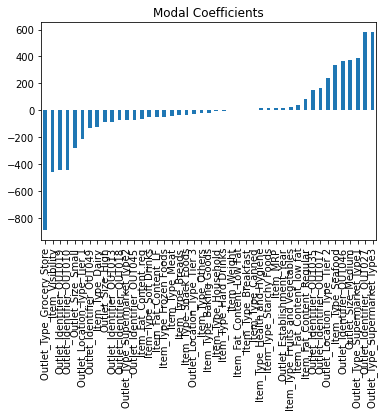

In [67]:
# check the magnitude of coefficients
predictors = X_train.columns
coef = pd.Series(m5.coef_, predictors).sort_values()
coef.plot(kind='bar', title='Modal Coefficients')

We can see that coefficients of Outlet_Identifier_OUT027 and Outlet_Type_Supermarket_Type3 (last 2) is much higher as compared to rest of the coefficients. Therefore the total sales of an item would be more driven by these two features. How can we reduce the magnitude of coefficients in our model? For this purpose, we have different types of regression techniques which uses `regularization` to overcome this problem.

---
<a id='m6'></a>

## Model 6 - Ridge Regression
This model solves a regression model where the loss function is the linear least squares function and regularization is given by the l2-norm.

Linear regression is the standard algorithm for regression that assumes a linear relationship between inputs and the target variable. An extension to linear regression invokes adding penalties to the loss function during training that encourages simpler models that have smaller coefficient values. These extensions are referred to as **regularized linear regression** or **penalized linear regression**.

**Ridge Regression** is a popular type of regularized linear regression that includes an L2 penalty. This has the effect of shrinking the coefficients for those input variables that do not contribute much to the prediction task.

In [68]:
from sklearn.linear_model import Ridge

In [69]:
# Modelling

m6 = Ridge(alpha=0.05, normalize=True)
m6.fit(X_train, y_train)
m6_pred = m6.predict(X_test)

In [70]:
m6_rmse = mean_squared_error(y_test, m6_pred)**(0.5)
m6_rmse

1098.9532837162678

In [71]:
m6_rmse_adj = (np.sum((y_test - m6_pred)**2) / (len(y_test) - X_test.shape[1] - 1))**(0.5)
m6_rmse_adj

1108.9736795548563

In [72]:
coeff = pd.DataFrame(X_train.columns)
coeff['Coefficient Estimate'] = pd.Series(m6.coef_)
coeff

,0,Coefficient Estimate
0,Item_Weight,-1.472758
1,Item_Visibility,-534.361939
2,Item_MRP,15.037281
3,Outlet_Establishment_Year,4.004740
4,Item_Fat_Content_LF,-74.753020
5,Item_Fat_Content_Low Fat,-27.489441
6,Item_Fat_Content_Regular,48.469517
7,Item_Fat_Content_low fat,2.254929
8,Item_Fat_Content_reg,-102.983100
9,Item_Type_Baking Goods,-11.799718


In [73]:
# R-Square
R2 = m6.score(X_test, y_test)
R2

0.568832163304414

In [74]:
# Adjusted R-Square
R2a = 1 - (1 - R2) * (len(y) - 1) / (len(y) - X_test.shape[1] - 1)
R2a

0.5665433167016889

In [75]:
row = {
    'Model' : 'Model 6 – Ridge Regression', 
    'RMSE' : m6_rmse, 
    'Adjusted_RMSE' : m6_rmse_adj, 
    'R2' : R2, 
    'Adjusted_R2' : R2a,
}
df_res = df_res.append(row, ignore_index=True)
df_res

,Model,RMSE,Adjusted_RMSE,R2,Adjusted_R2
0,Model 1 - Mean,1675.463558,1679.408925,-0.002208,-0.006540
1,Model 2 - Average Sales by Location - Tier 1,1561.322280,1561.976511,0.000000,-0.001816
2,Model 2 - Average Sales by Location - Tier 3,1912.165871,1912.736922,0.000000,-0.001816
3,Model 2 - Average Sales by Location - Tier 2,1520.270530,1520.816703,0.000000,-0.001816
4,Model 3 – Linear Regression (2 features),1375.840203,1376.648016,0.324191,0.323662
5,Model 4 – Linear Regression (4 features),1375.854383,1376.931794,0.324177,0.323939
6,Model 5 – Linear Regression (more features),1100.200160,1110.231925,0.567853,0.565559
7,Model 6 – Ridge Regression,1098.953284,1108.973680,0.568832,0.566543


### Choose best lambda

------------------------------
Lambda: 0.01
RMSE: 1099.7467152113004
R2: 0.5682093422195967
Adjusted R2: 0.5665433167016889


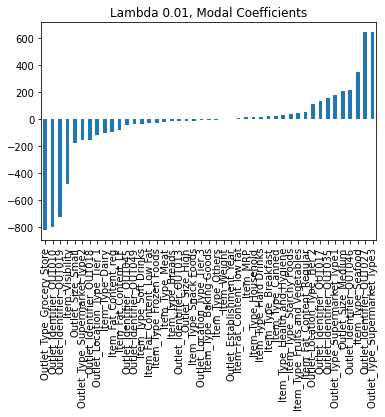

------------------------------
Lambda: 0.05
RMSE: 1098.9532837162678
R2: 0.568832163304414
Adjusted R2: 0.5665433167016889


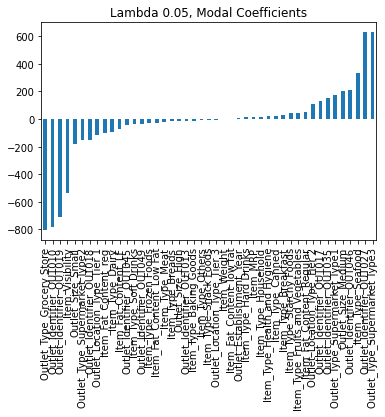

------------------------------
Lambda: 0.1
RMSE: 1099.8781073443256
R2: 0.5681061597614914
Adjusted R2: 0.5665433167016889


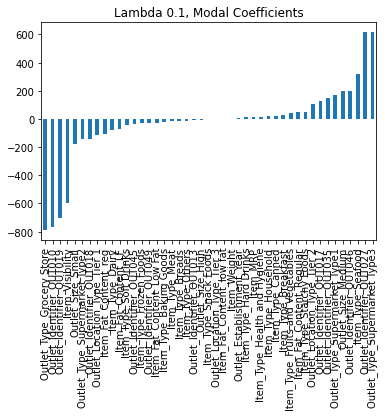

------------------------------
Lambda: 0.5
RMSE: 1141.9333008399694
R2: 0.5344467415475747
Adjusted R2: 0.5665433167016889


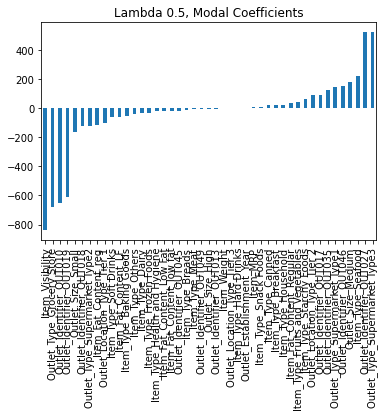

------------------------------
Lambda: 1.0
RMSE: 1208.2058837183392
R2: 0.4788415456187347
Adjusted R2: 0.5665433167016889


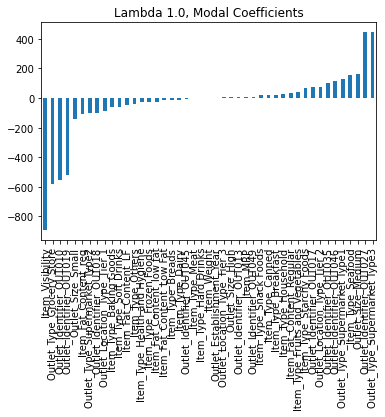

------------------------------
Lambda: 5.0
RMSE: 1452.598072238949
R2: 0.24668117264091194
Adjusted R2: 0.5665433167016889


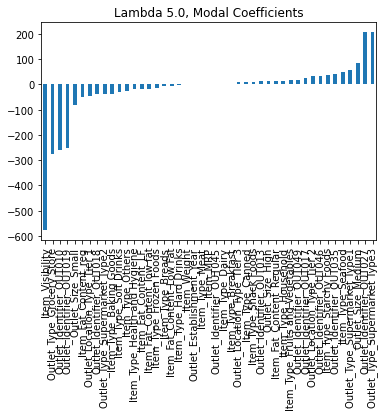

------------------------------
Lambda: 10.0
RMSE: 1540.1691153492443
R2: 0.1531144643128689
Adjusted R2: 0.5665433167016889


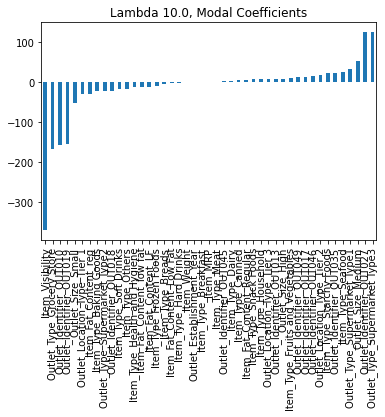

In [76]:
import matplotlib.pyplot as plt

lambdas = [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]
for lam in lambdas:
    m6 = Ridge(alpha=lam, normalize=True)
    m6.fit(X_train, y_train)
    m6_pred = m6.predict(X_test)
    
    print(f'-'*30)
    print(f'Lambda: {lam}')
    print(f'RMSE: {mean_squared_error(y_test, m6_pred)**(0.5)}')
    print(f'R2: {m6.score(X_test, y_test)}')
    print(f'Adjusted R2: {1 - (1 - R2) * (len(y) - 1) / (len(y) - X_test.shape[1] - 1)}')
    
    predictors = X_train.columns
    coef = pd.Series(m6.coef_, predictors).sort_values()
    coef.plot(kind='bar', title=f'Lambda {lam}, Modal Coefficients')
    plt.show()

You can see that, as we increase the value of alpha, the magnitude of the coefficients decreases, where the values reaches to zero but not absolute zero.

But if you calculate R-square for each alpha, we will see that the value of (Adjusted) R-square will be maximum at alpha=0.05 (lambda). So we have to choose it wisely by iterating it through a range of values and using the one which gives us lowest error.

### Ridge Regression model Evaluation with Cross-Validation
We can also evaluate the Ridge Regression model on the housing dataset using repeated 10-fold cross-validation and report the average mean absolute error (MAE) on the dataset.

In [27]:
# Evaluate an ridge regression model on the dataset
from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge

# based on df_pred
# Modelling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define model
m6a = Ridge(alpha=1.0)

# Define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

# Evaluate model
scores = cross_val_score(m6a, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# Force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean MAE: 852.844 (34.613)


In [12]:
X_train

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
1921,FDN08,7.720,Regular,0.147904,Fruits and Vegetables,116.6466,OUT010,1998,NaN,Tier 3,Grocery Store
655,NCJ42,19.750,Low Fat,0.014301,Household,103.0332,OUT046,1997,Small,Tier 1,Supermarket Type1
2229,FDY47,NaN,Regular,0.054221,Breads,129.1310,OUT027,1985,Medium,Tier 3,Supermarket Type3
2537,FDN45,19.350,Low Fat,0.118342,Snack Foods,222.6088,OUT045,2002,NaN,Tier 2,Supermarket Type1
3528,FDY16,18.350,Regular,0.092150,Frozen Foods,184.8266,OUT013,1987,High,Tier 3,Supermarket Type1
...,...,...,...,...,...,...,...,...,...,...,...
5734,FDY08,9.395,Regular,0.286345,Fruits and Vegetables,139.1838,OUT010,1998,NaN,Tier 3,Grocery Store
5191,FDC41,15.600,Low Fat,0.117575,Frozen Foods,75.6670,OUT017,2007,NaN,Tier 2,Supermarket Type1
5390,NCQ53,17.600,Low Fat,0.018944,Health and Hygiene,237.3590,OUT045,2002,NaN,Tier 2,Supermarket Type1
860,FDL46,20.350,low fat,0.054363,Snack Foods,117.9466,OUT017,2007,NaN,Tier 2,Supermarket Type1


### Tuning Ridge Hyperparameters
How do we know that the default hyperparameters of alpha=1.0 is appropriate for our dataset? It is good practice to test a suite of different configurations and discover what works best for our dataset.
- One approach would be to grid search alpha values from perhaps 1e-5 to 100 on a log scale and discover what works best for a dataset. 
- Another approach would be to test values between 0.0 and 1.0 with a grid separation of 0.01. We will try the latter in this case.

In [29]:
# Grid search hyperparameters for ridge regression
from numpy import arange
from pandas import read_csv
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge

# Define model
m6b = Ridge()

# Define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Define grid
grid = dict()
grid['alpha'] = arange(0, 1, 0.01)

# Define search
search = GridSearchCV(m6b, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# Perform the search
results = search.fit(X, y)

# Summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

MAE: -838.633
Config: {'alpha': 0.99}


The scikit-learn library also provides a built-in version of the algorithm that automatically finds good hyperparameters via the [RidgeCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) class.

By default, the model will only test the alpha values (0.1, 1.0, 10.0). We can change this to a grid of values between 0 and 1 with a separation of 0.01 as we did on the previous example by setting the “alphas” argument. Running the example below fits the model and discovers the hyperparameters that give the best results using cross-validation.

In [31]:
# Use automatically configured the ridge regression algorithm
from numpy import arange
from pandas import read_csv
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold

# Define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Define model
m6c = RidgeCV(alphas=arange(0, 1, 0.01), cv=cv, scoring='neg_mean_absolute_error')

# Fit model
m6c.fit(X, y)

# Summarize chosen configuration
print('alpha: %f' % m6c.alpha_)

alpha: 0.990000


---
<a id='m7'></a>

## Model 7 - Lasso Regression

In [77]:
from sklearn.linear_model import Lasso

In [78]:
# Modelling

m7 = Lasso(alpha=0.3, normalize=True)
m7.fit(X_train, y_train)
m7_pred = m7.predict(X_test)

In [79]:
m7_rmse = mean_squared_error(y_test, m7_pred)**(0.5)
m7_rmse

1097.3689660313044

In [80]:
m7_rmse_adj = (np.sum((y_test - m7_pred)**2) / (len(y_test) - X_test.shape[1] - 1))**(0.5)
m7_rmse_adj

1107.3749158597006

In [81]:
coeff = pd.DataFrame(X_train.columns)
coeff['Coefficient Estimate'] = pd.Series(m7.coef_)
coeff

,0,Coefficient Estimate
0,Item_Weight,-0.000000
1,Item_Visibility,-103.088030
2,Item_MRP,15.408020
3,Outlet_Establishment_Year,0.000000
4,Item_Fat_Content_LF,-0.000000
5,Item_Fat_Content_Low Fat,-0.000000
6,Item_Fat_Content_Regular,30.150153
7,Item_Fat_Content_low fat,0.000000
8,Item_Fat_Content_reg,-0.000000
9,Item_Type_Baking Goods,-0.000000


In [82]:
# R-Square
R2 = m7.score(X_test, y_test)
R2

0.5700744625629316

In [83]:
# Adjusted R-Square
R2a = 1 - (1 - R2) * (len(y) - 1) / (len(y) - X_test.shape[1] - 1)
R2a

0.5677922106831783

In [84]:
row = {
    'Model' : 'Model 7 – Lasso Regression', 
    'RMSE' : m7_rmse, 
    'Adjusted_RMSE' : m7_rmse_adj, 
    'R2' : R2, 
    'Adjusted_R2' : R2a,
}
df_res = df_res.append(row, ignore_index=True)
df_res

,Model,RMSE,Adjusted_RMSE,R2,Adjusted_R2
0,Model 1 - Mean,1675.463558,1679.408925,-0.002208,-0.006540
1,Model 2 - Average Sales by Location - Tier 1,1561.322280,1561.976511,0.000000,-0.001816
2,Model 2 - Average Sales by Location - Tier 3,1912.165871,1912.736922,0.000000,-0.001816
3,Model 2 - Average Sales by Location - Tier 2,1520.270530,1520.816703,0.000000,-0.001816
4,Model 3 – Linear Regression (2 features),1375.840203,1376.648016,0.324191,0.323662
5,Model 4 – Linear Regression (4 features),1375.854383,1376.931794,0.324177,0.323939
6,Model 5 – Linear Regression (more features),1100.200160,1110.231925,0.567853,0.565559
7,Model 6 – Ridge Regression,1098.953284,1108.973680,0.568832,0.566543
8,Model 7 – Lasso Regression,1097.368966,1107.374916,0.570074,0.567792


### Choose best lambda

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15024008.88915062, tolerance: 1764405.4984319524
  model = cd_fast.enet_coordinate_descent(


------------------------------
Lambda: 0.01
RMSE: 1099.9052154406982
R2: 0.5680848701948678
Adjusted R2: 0.5677922106831783


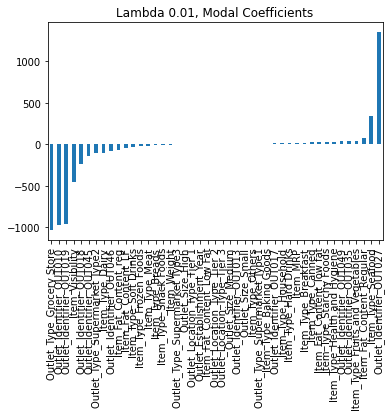

------------------------------
Lambda: 0.05
RMSE: 1098.969681953747
R2: 0.5688192957049711
Adjusted R2: 0.5677922106831783


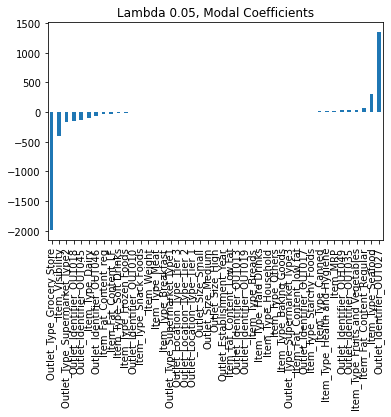

------------------------------
Lambda: 0.1
RMSE: 1098.2800350906334
R2: 0.5693602917337139
Adjusted R2: 0.5677922106831783


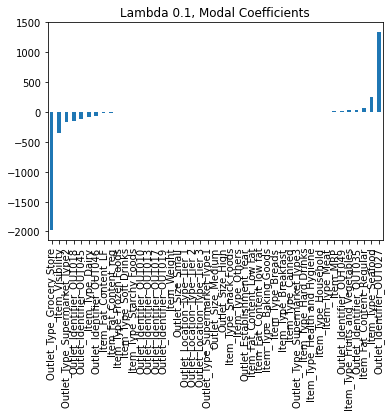

------------------------------
Lambda: 0.2
RMSE: 1097.4867541045571
R2: 0.5699821639468095
Adjusted R2: 0.5677922106831783


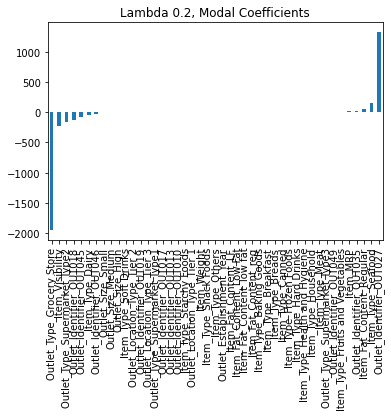

------------------------------
Lambda: 0.3
RMSE: 1097.3689660313044
R2: 0.5700744625629316
Adjusted R2: 0.5677922106831783


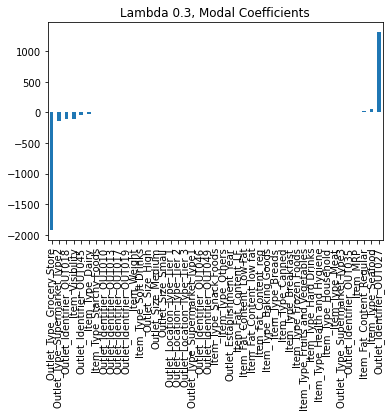

------------------------------
Lambda: 0.5
RMSE: 1098.4719624784768
R2: 0.5692097676898293
Adjusted R2: 0.5677922106831783


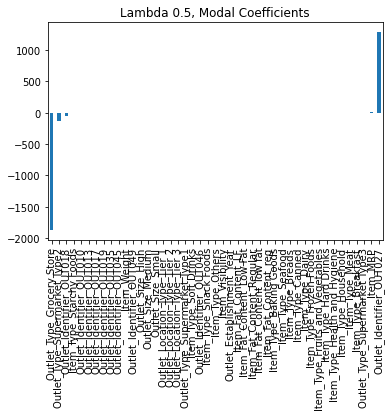

------------------------------
Lambda: 1.0
RMSE: 1104.7167691599038
R2: 0.564297765010287
Adjusted R2: 0.5677922106831783


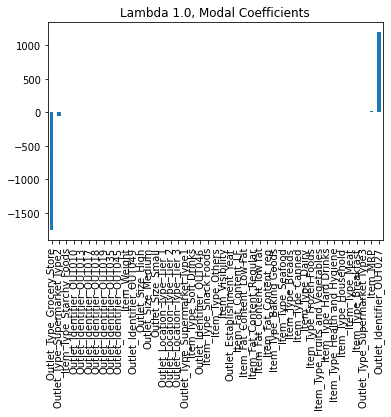

------------------------------
Lambda: 5.0
RMSE: 1268.5805478272107
R2: 0.42545507849082365
Adjusted R2: 0.5677922106831783


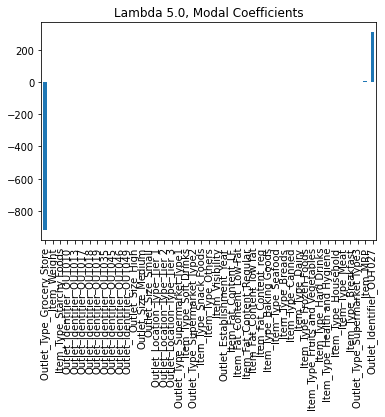

------------------------------
Lambda: 10.0
RMSE: 1570.8987972346351
R2: 0.1189829583512656
Adjusted R2: 0.5677922106831783


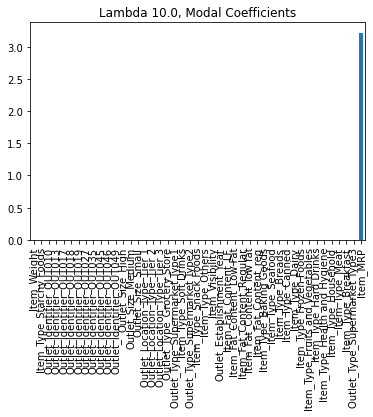

In [85]:
import matplotlib.pyplot as plt

lambdas = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1.0, 5.0, 10.0]
for lam in lambdas:
    m7 = Lasso(alpha=lam, normalize=True)
    m7.fit(X_train, y_train)
    m7_pred = m7.predict(X_test)
    
    print(f'-'*30)
    print(f'Lambda: {lam}')
    print(f'RMSE: {mean_squared_error(y_test, m7_pred)**(0.5)}')
    print(f'R2: {m7.score(X_test, y_test)}')
    print(f'Adjusted R2: {1 - (1 - R2) * (len(y) - 1) / (len(y) - X_test.shape[1] - 1)}')
    
    predictors = X_train.columns
    coef = pd.Series(m7.coef_, predictors).sort_values()
    coef.plot(kind='bar', title=f'Lambda {lam}, Modal Coefficients')
    plt.show()

So, we can see that even at small values of alpha, the magnitude of coefficients have reduced a lot. By looking at the plots, we can see that as we increased the value of alpha, coefficients were approaching towards zero, but if you see in case of lasso, even at smaller alpha’s, our coefficients are reducing to absolute zeroes. Therefore, lasso selects the only some feature while reduces the coefficients of others to zero. This property is known as feature selection and which is absent in case of ridge. Lambda=0.3 seems to give the least RMSE.

---
<a id='m7b'></a>

## Model 7b - Least Angle Regression (LARS) Regression
Lasso Regression is a popular type of regularized linear regression that includes an L1 penalty. This has the effect of shrinking the coefficients for those input variables that do not contribute much to the prediction task.

**Least Angle Regression** or **LARS** for short provides an alternate, efficient way of fitting a Lasso regularized regression model that does not require any hyperparameters.

**LARS Regression** provides an alternate way to train a Lasso regularized linear regression model that adds a penalty to the loss function during training.

**Least Angle Regression, LAR** or **LARS** for short, is an alternative approach to solving the optimization problem of fitting the penalized model. Technically, LARS is a forward stepwise version of feature selection for regression that can be adapted for the Lasso model. Unlike the Lasso, it does not require a hyperparameter that controls the weighting of the penalty in the loss function. Instead, the weighting is discovered automatically by LARS.

The scikit-learn Python machine learning library provides an implementation of the LARS penalized regression algorithm via the [Lars](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lars.html) class.

In [49]:
# Evaluate LARS regression model on the dataset
from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lars


# Define model
m7b = Lars()

# Define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Evaluate model
scores = cross_val_score(m7b, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# Force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean MAE: 5453.322 (22014.469)


We may decide to use the LARS Regression as our final model and make predictions on new data. This can be achieved by fitting the model on all available data and calling the predict() function, passing in a new row of data.

In [50]:
# Make a prediction with LARS regression model on the dataset
from pandas import read_csv
from sklearn.linear_model import Lars

# Fit model
m7b.fit(X_train, y_train)

# Make a prediction
yhat = m7b.predict(X_test[:1])

# Summarize prediction
print('Predicted: %.3f' % yhat)

Predicted: 1341.983


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=4.837e-01, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=3.290e-01, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.729e-01, with an

### Tuning LARS Hyperparameters
As part of the LARS training algorithm, it automatically discovers the best value for the lambda hyperparameter used in the Lasso algorithm.

This hyperparameter is referred to as the “alpha” argument in the scikit-learn implementation of Lasso and LARS.

Nevertheless, the process of automatically discovering the best model and alpha hyperparameter is still based on a single training dataset.

An alternative approach is to fit the model on multiple subsets of the training dataset and choose the best internal model configuration across the folds, in this case, the value of alpha. Generally, this is referred to as a cross-validation estimator.

The scikit-learn libraries offer a cross-validation version of the LARS for finding a more robust value for alpha via the [LarsCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LarsCV.html) class.

In [44]:
# Use automatically configured the lars regression algorithm
from numpy import arange
from pandas import read_csv
from sklearn.linear_model import LarsCV
from sklearn.model_selection import RepeatedKFold

# Define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Define model
m7c = LarsCV(cv=cv, n_jobs=-1, max_iter=4)

# Fit model
m7c.fit(X_train, y_train)

# Summarize chosen configuration
print('alpha: %f' % m7c.alpha_)

alpha: 0.457618


In [43]:
from sklearn.linear_model import LassoLars

m6c = LassoLars(alpha=.0)
m6c.fit(X_train, y_train)
m6c.coef_

array([-12.26469024,  15.581799  ])

---
<a id='m8'></a>

## Model 8 - Elastic Net Regression
Elastic net is basically a combination of both L1 and L2 regularization. So if you know elastic net, you can implement both Ridge and Lasso by tuning the parameters. So it uses both L1 and L2 penality term.

Note, here we had two parameters `alpha` and `l1_ratio`.

So how do we adjust the lambdas in order to control the L1 and L2 penalty term? Let us understand by an example. You are trying to catch a fish from a pond. And you only have a net, then what would you do? Will you randomly throw your net? No, you will actually wait until you see one fish swimming around, then you would throw the net in that direction to basically collect the entire group of fishes. Therefore even if they are correlated, we still want to look at their entire group.

Elastic regression works in a similar way. Let’ say, we have a bunch of correlated independent variables in a dataset, then elastic net will simply form a group consisting of these correlated variables. Now if any one of the variable of this group is a strong predictor (meaning having a strong relationship with dependent variable), then we will include the entire group in the model building, because omitting other variables (like what we did in lasso) might result in losing some information in terms of interpretation ability, leading to a poor model performance.

So, if you look at the code below, we need to define `alph`a and `l1_ratio` while defining the model. Alpha and l1_ratio are the parameters which you can set accordingly if you wish to control the L1 and L2 penalty separately. Actually, we have
```
Alpha = a + b           and     l1_ratio =  a / (a+b)
```
where, `a` and `b` are weights assigned to L1 and L2 term respectively. So when we change the values of alpha and l1_ratio, a and b are set accordingly such that they control trade off between L1 and L2 as:
```
a * (L1 term) + b* (L2 term)
```
Let alpha (or a+b) = 1, and now consider the following cases:
- If l1_ratio=1, therefore if we look at the formula of l1_ratio, we can see that l1_ratio can only be equal to 1 if a=1, which implies b=0. Therefore, it will be a lasso penalty.
- Similarly if l1_ratio=0, implies a=0. Then the penalty will be a ridge penalty.

For l1_ratio between 0 and 1, the penalty is the combination of ridge and lasso.

In [86]:
from sklearn.linear_model import ElasticNet

In [87]:
# Modelling

m8 = ElasticNet(alpha=1, l1_ratio=0.5, normalize=True)
m8.fit(X_train, y_train)
m8_pred = m8.predict(X_test)

In [88]:
m8_rmse = mean_squared_error(y_test, m8_pred)**(0.5)
m8_rmse

1674.928214322048

In [89]:
m8_rmse_adj = (np.sum((y_test - m8_pred)**2) / (len(y_test) - X_test.shape[1] - 1))**(0.5)
m8_rmse_adj

1690.2004228475748

In [90]:
coeff = pd.DataFrame(X_train.columns)
coeff['Coefficient Estimate'] = pd.Series(m8.coef_)
coeff

,0,Coefficient Estimate
0,Item_Weight,0.000000
1,Item_Visibility,-1.407650
2,Item_MRP,0.005007
3,Outlet_Establishment_Year,0.001995
4,Item_Fat_Content_LF,-0.000000
5,Item_Fat_Content_Low Fat,-0.000000
6,Item_Fat_Content_Regular,0.000000
7,Item_Fat_Content_low fat,-0.000000
8,Item_Fat_Content_reg,-0.000000
9,Item_Type_Baking Goods,-0.041398


In [91]:
# R-Square
R2 = m8.score(X_test, y_test)
R2

-0.001567656521772598

In [92]:
# Adjusted R-Square
R2a = 1 - (1 - R2) * (len(y) - 1) / (len(y) - X_test.shape[1] - 1)
R2a

-0.006884460172059237

So we get the value of R-Square, which is very less than both ridge and lasso. Can you think why? The reason behind this downfall is basically we didn’t have a large set of features. `Elastic regression generally works well when we have a big dataset`.

### Hyperparameters tuning

In [93]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

In [94]:
%%time
# Use grid search to tune the parameters:

parametersGrid = {
    "max_iter": [1000, 5000, 10000],
    "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10],
    "l1_ratio": np.arange(0.0, 1.0, 0.1)}

m8 = ElasticNet()
grid = GridSearchCV(m8, parametersGrid, scoring='r2', cv=10, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)
m8_pred = grid.predict(X_test)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 1291 tasks      | elapsed:   37.9s


CPU times: user 4.04 s, sys: 1.86 s, total: 5.9 s
Wall time: 44.9 s


[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:   44.8s finished


In [95]:
grid

GridSearchCV(cv=10, estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'max_iter': [1000, 5000, 10000]},
             scoring='r2', verbose=1)

In [96]:
sorted(grid.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_alpha',
 'param_l1_ratio',
 'param_max_iter',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'split5_test_score',
 'split6_test_score',
 'split7_test_score',
 'split8_test_score',
 'split9_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [97]:
grid.best_estimator_

ElasticNet(alpha=0.1, l1_ratio=0.9)

In [98]:
grid.best_params_

{'alpha': 0.1, 'l1_ratio': 0.9, 'max_iter': 1000}

In [99]:
m8 = ElasticNet(alpha=0.1, l1_ratio=0.9, normalize=True)
m8.fit(X_train, y_train)
m8_pred = m8.predict(X_test)

In [100]:
# R-Square
R2 = m8.score(X_test, y_test)
R2

0.03029801842061941

In [101]:
# Adjusted R-Square
R2a = 1 - (1 - R2) * (len(y) - 1) / (len(y) - X_test.shape[1] - 1)
R2a

0.02515037312498747

In [102]:
print(f'-'*30)
print(f'Best params: {grid.best_params_}')
print(f'RMSE: {mean_squared_error(y_test, m8_pred)**(0.5)}')
print(f'R2: {m8.score(X_test, y_test)}')
print(f'Adjusted R2: {1 - (1 - R2) * (len(y) - 1) / (len(y) - X_test.shape[1] - 1)}')

------------------------------
Best params: {'alpha': 0.1, 'l1_ratio': 0.9, 'max_iter': 1000}
RMSE: 1648.068255222884
R2: 0.03029801842061941
Adjusted R2: 0.02515037312498747


In [103]:
m8_rmse = mean_squared_error(y_test, m8_pred)**(0.5)
m8_rmse

1648.068255222884

In [104]:
m8_rmse_adj = (np.sum((y_test - m8_pred)**2) / (len(y_test) - X_test.shape[1] - 1))**(0.5)
m8_rmse_adj

1663.0955512244936

In [105]:
row = {
    'Model' : 'Model 8 – ElasticNet Regression', 
    'RMSE' : m8_rmse, 
    'Adjusted_RMSE' : m8_rmse_adj, 
    'R2' : R2, 
    'Adjusted_R2' : R2a,
}
df_res = df_res.append(row, ignore_index=True)
df_res

,Model,RMSE,Adjusted_RMSE,R2,Adjusted_R2
0,Model 1 - Mean,1675.463558,1679.408925,-0.002208,-0.006540
1,Model 2 - Average Sales by Location - Tier 1,1561.322280,1561.976511,0.000000,-0.001816
2,Model 2 - Average Sales by Location - Tier 3,1912.165871,1912.736922,0.000000,-0.001816
3,Model 2 - Average Sales by Location - Tier 2,1520.270530,1520.816703,0.000000,-0.001816
4,Model 3 – Linear Regression (2 features),1375.840203,1376.648016,0.324191,0.323662
5,Model 4 – Linear Regression (4 features),1375.854383,1376.931794,0.324177,0.323939
6,Model 5 – Linear Regression (more features),1100.200160,1110.231925,0.567853,0.565559
7,Model 6 – Ridge Regression,1098.953284,1108.973680,0.568832,0.566543
8,Model 7 – Lasso Regression,1097.368966,1107.374916,0.570074,0.567792
9,Model 8 – ElasticNet Regression,1648.068255,1663.095551,0.030298,0.025150


---
<a id='sum'></a>

## Summary
The best model for this dataset (based on test metrics) seems to be Lasso regression.

In [106]:
df_res

,Model,RMSE,Adjusted_RMSE,R2,Adjusted_R2
0,Model 1 - Mean,1675.463558,1679.408925,-0.002208,-0.006540
1,Model 2 - Average Sales by Location - Tier 1,1561.322280,1561.976511,0.000000,-0.001816
2,Model 2 - Average Sales by Location - Tier 3,1912.165871,1912.736922,0.000000,-0.001816
3,Model 2 - Average Sales by Location - Tier 2,1520.270530,1520.816703,0.000000,-0.001816
4,Model 3 – Linear Regression (2 features),1375.840203,1376.648016,0.324191,0.323662
5,Model 4 – Linear Regression (4 features),1375.854383,1376.931794,0.324177,0.323939
6,Model 5 – Linear Regression (more features),1100.200160,1110.231925,0.567853,0.565559
7,Model 6 – Ridge Regression,1098.953284,1108.973680,0.568832,0.566543
8,Model 7 – Lasso Regression,1097.368966,1107.374916,0.570074,0.567792
9,Model 8 – ElasticNet Regression,1648.068255,1663.095551,0.030298,0.025150
